In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from IPython.display import display
from collections import Counter
import allel


In [2]:
# Load data
callset = allel.read_vcf('../data/raw/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz',
                         fields=['samples', 'calldata/GT'],
                         alt_number=1)


In [3]:
# Extract genotype array
gt = callset['calldata/GT']

# Convert to diploid codes: 0 (hom ref), 1 (het), 2 (hom alt)
geno = allel.GenotypeArray(gt).to_n_alt().T 

# Count missing values
missing_count = np.sum(geno < 0)
print(f"Total missing genotypes: {missing_count}")

# Convert to dataframe
df_geno = pd.DataFrame(geno)

Total missing genotypes: 0


In [4]:
df_geno.shape

(2504, 1103547)

In [5]:
df_geno.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1103537,1103538,1103539,1103540,1103541,1103542,1103543,1103544,1103545,1103546
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_geno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2504 entries, 0 to 2503
Columns: 1103547 entries, 0 to 1103546
dtypes: int8(1103547)
memory usage: 2.6 GB


In [7]:
# Compute variance for each SNP
snp_variances = df_geno.var(axis=0)

# Select top 10,000 most variable SNPs
top_snps = snp_variances.nlargest(10000).index

# Subset the genotype matrix to those top SNPs
df_geno_top = df_geno[top_snps]

# Standardize the matrix pre PCA
scaler = StandardScaler()
X_std = scaler.fit_transform(df_geno_top)


Explained variance by PC1: 0.1875949502054576
Explained variance by PC2: 0.0726913992404625
Explained variance by PC3: 0.01790026368218306
Explained variance by PC4: 0.014759035934174096
Explained variance by PC5: 0.01026593184076825
Explained variance by PC6: 0.007912127308167191
Cumulative variance: [0.18759495 0.26028635 0.27818661 0.29294565 0.30321158 0.31112371]


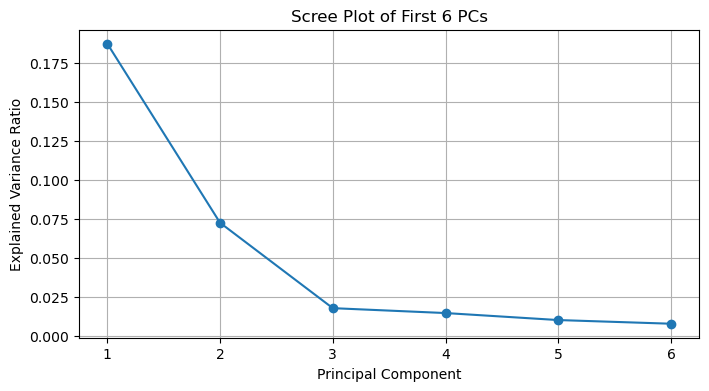

In [8]:
# Run PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_std)

# Print explained variance
explained = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained[0]}")
print(f"Explained variance by PC2: {explained[1]}")
print(f"Explained variance by PC3: {explained[2]}")
print(f"Explained variance by PC4: {explained[3]}")
print(f"Explained variance by PC5: {explained[4]}")
print(f"Explained variance by PC6: {explained[5]}")

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative variance: {cumulative_variance}")


# Plot explained variance by principal comp
plt.figure(figsize=(8, 4))
plt.plot(
    np.arange(1, 7),  # x: components 1 to 6
    pca.explained_variance_ratio_,  # y: their variance
    marker='o'
)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of First 6 PCs')
plt.grid(True)
plt.xticks(np.arange(1, 7))
plt.show()


Scree plot showing the variance explained by the first six principal components from PCA. The explained variance begins to level off after the third component, so I will use three principal components to capture the most meaningful variance in the data.

In [9]:
# Re-run PCA with optimized number of components: 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)

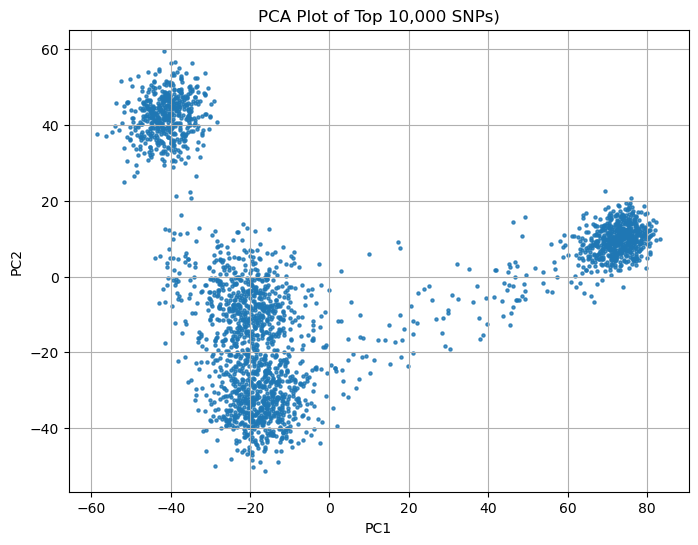

In [10]:
# Plot the first 2 principal components
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot of Top 10,000 SNPs)')
plt.grid(True)
plt.show()

A 2D scatter plot; From the plot, you observe several distinct groupings, indicating that PCA successfully captured population structure in the genetic data.

In [11]:
# Load the metadata
sample_info = pd.read_csv("../data/raw/20130606_g1k.ped.txt", sep="\t")

print(sample_info.columns.tolist())

# Preview the data
sample_info.head()


['Family ID', 'Individual ID', 'Paternal ID', 'Maternal ID', 'Gender', 'Phenotype', 'Population', 'Relationship', 'Siblings', 'Second Order', 'Third Order', 'Other Comments']


,Family ID,Individual ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Other Comments
0,BB01,HG01879,0,0,1,0,ACB,father,0,0,0,0
1,BB01,HG01880,0,0,2,0,ACB,mother,0,0,0,0
2,BB01,HG01881,HG01879,HG01880,2,0,ACB,child,0,0,0,0
3,BB02,HG01882,0,0,1,0,ACB,father,0,0,0,0
4,BB02,HG01883,0,0,2,0,ACB,mother,0,0,0,0


In [12]:
# Convert VCF sample IDs to DataFrame
sample_ids = pd.Series(callset['samples'], name='Individual ID')

# Merge with population labels
true_label_merge = pd.merge(sample_ids.to_frame(), sample_info, on='Individual ID', how='left')

# Check for missing population labels
missing = true_label_merge['Population'].isna().sum()
print(f"Samples with missing population label: {missing}")

Samples with missing population label: 0


In [13]:
true_labels = true_label_merge['Population'].values

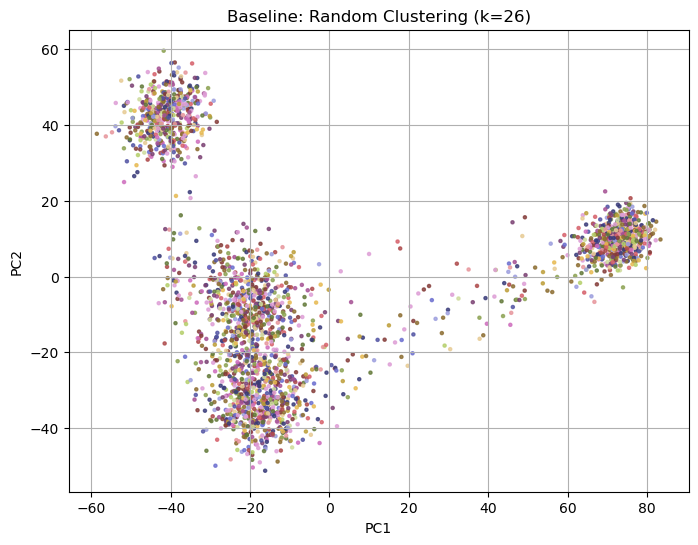

In [14]:
# Set number of clusters to 26 for the known 26 populations as defined by the 1000 Genomes Project
k = len(np.unique(true_labels))

# Create random cluster labels
np.random.seed(42)
random_labels = np.random.randint(0, k, size=X_pca.shape[0])

# Get a base colormap and sample colors
base_cmap = plt.get_cmap('tab20b')
colors = base_cmap(np.linspace(0, 1, k))
custom_cmap = ListedColormap(colors)

# Plot random clusters in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=random_labels,
    cmap=custom_cmap,
    s=5,
    alpha=0.8
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Baseline: Random Clustering (k={k})')
plt.grid(True)
plt.show()


This code generates a random clustering baseline in 2-D PCA space. It serves as a visual reference for evaluating whether other clustering methods reveal patterns beyond chance.

In [15]:
def purity_score(y_true, y_pred):
    # Create a contingency matrix
    contingency_matrix = pd.crosstab(y_true, y_pred)
    # Purity is the sum of the largest count in each predicted cluster
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Evaluate ARI and NMI
ari = adjusted_rand_score(true_labels, random_labels)
nmi = normalized_mutual_info_score(true_labels, random_labels)
purity = purity_score(true_labels, random_labels)

# Print all metrics
print("Random Clustering Performance\n")
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")
print(f"Purity Score: {purity}")


Random Clustering Performance

Adjusted Rand Index: 0.00017068813623577787
Normalized Mutual Information: 0.042342145052493056
Purity Score: 0.08266773162939298


This code evaluates the performance of a baseline model using random clustering. It serves as a numerical reference to determine whether other clustering methods offer meaningful improvements.

In [16]:
# Define purity function
def purity_score(y_true, y_pred):
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

In [17]:
# Define number of clusters to match number of unique populations
k = len(np.unique(true_labels))

# Run k-means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Evaluate clustering performance
ari = adjusted_rand_score(true_labels, kmeans_labels)
nmi = normalized_mutual_info_score(true_labels, kmeans_labels)
purity = purity_score(true_labels, kmeans_labels)

# Print results
print(f"K-Means Clustering Performance (k={k})\n")
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")
print(f"Purity Score: {purity}")


K-Means Clustering Performance (k=26)

Adjusted Rand Index: 0.19075306750425727
Normalized Mutual Information: 0.5068878806132646
Purity Score: 0.3055111821086262


Compared to the random baseline, K-means achieved  higher ARI, NMI, and Purity. However, the scores are still relatively low, indicating that K-means only partially recovered the underlying population structure and may not be the most effective method for this task.

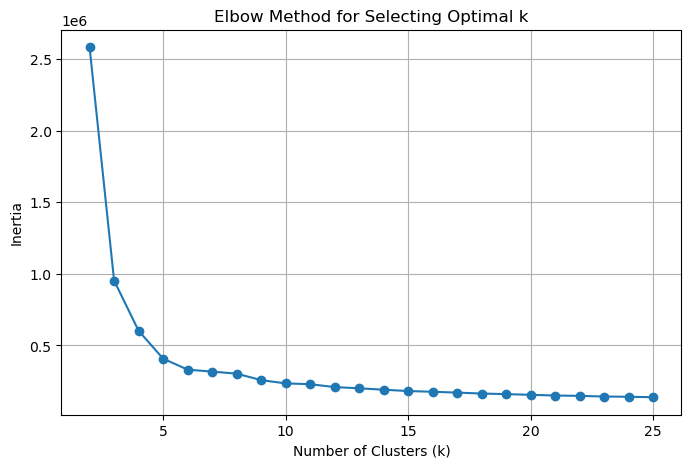

     k       inertia
0    2  2.583625e+06
1    3  9.538378e+05
2    4  6.027417e+05
3    5  4.081652e+05
4    6  3.312923e+05
5    7  3.172749e+05
6    8  3.034709e+05
7    9  2.580140e+05
8   10  2.351764e+05
9   11  2.295039e+05
10  12  2.093945e+05
11  13  2.007959e+05
12  14  1.909493e+05
13  15  1.816427e+05
14  16  1.768268e+05
15  17  1.706767e+05
16  18  1.641988e+05
17  19  1.602591e+05
18  20  1.551964e+05
19  21  1.505392e+05
20  22  1.479358e+05
21  23  1.435209e+05
22  24  1.416940e+05
23  25  1.385208e+05


In [18]:
# Range of k values to test
k_max = len(np.unique(true_labels))
ks = range(2, k_max)
inertias = []

# Fit KMeans for each k and store inertia
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Selecting Optimal k')
plt.grid(True)
plt.show()

# Also print numerical values in a table
elbow_df = pd.DataFrame({'k': ks, 'inertia': inertias})
print(elbow_df)


This code uses the elbow method to find the optimal number of clusters for K-means. It fits models for a range of k values (2 to 26), notes the inertia (within-cluster variance), and plots the results. The "elbow" in the curve indicates where adding more clusters has diminishing returns. Based on the plot, k=5 is the best choice—likely because the model is capturing the structure of the five major superpopulations present in the dataset (AFR:African, EUR:European, EAS:East Asian, SAS:South Asian, AMR:Admixed American)

In [19]:
# Set k to 5 based on elbow plot
k = 5

# Run k-means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Evaluate clustering
ari = adjusted_rand_score(true_labels, kmeans_labels)
nmi = normalized_mutual_info_score(true_labels, kmeans_labels)
purity = purity_score(true_labels, kmeans_labels)

# Print results
print(f"K-Means Clustering Performance(k={k})\n")
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")
print(f"Purity Score: {purity}")


K-Means Clustering Performance(k=5)

Adjusted Rand Index: 0.2182359020556783
Normalized Mutual Information: 0.5831835563773446
Purity Score: 0.20287539936102236


K-means clustering with k=5 outperformed k=26 on both ARI and NMI, indicating better alignment with the true population structure. Although k=26 yielded a higher purity score, this likely reflects over-fragmentation rather than meaningful clusters. Despite its relative improvement, the low performance of k=5 suggests that k-means may not be well-suited for this task.

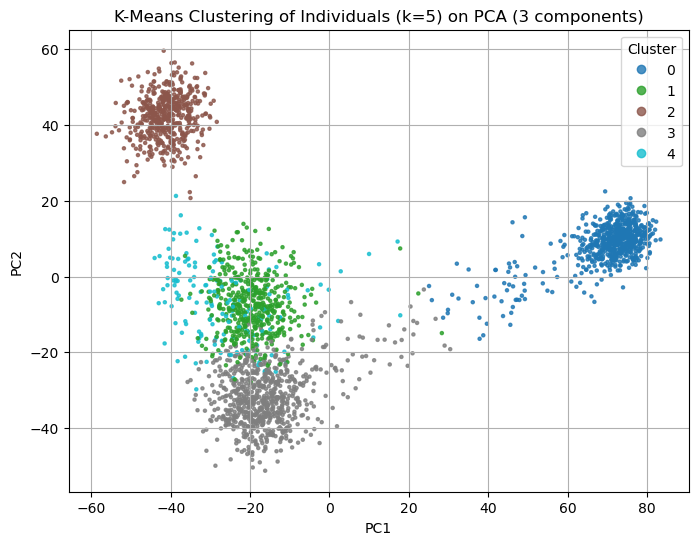

In [20]:
# Visualize the results of K-means clustering (k=5) in 2-D PCA space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels,
    cmap='tab10',
    s=5,
    alpha=0.8
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering of Individuals (k=5) on PCA (3 components)')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()



K-Means Clustering Visualization; This plot uses K-means clustering with k=5 on data reduced to 3 principal components, but only the first 2 components are plotted, creating a 2-D visualization. From the plot, we can see that K-means clustering resulted in distinct clusters. However, some overlap and spread among the clusters indicate that the separation is not perfect, and finer population distinctions may not be well captured with these parameters.

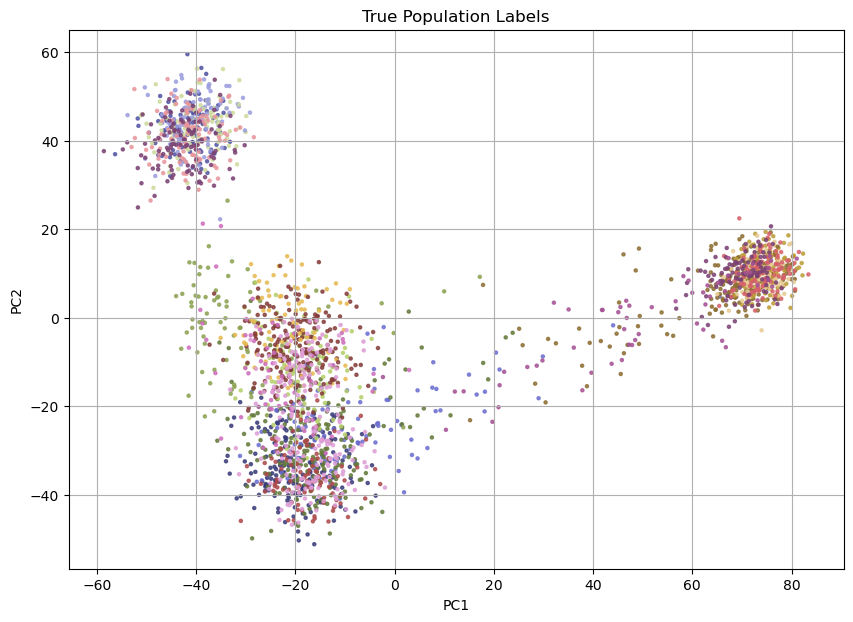

In [21]:
# Factorize true labels
true_labels_int = pd.factorize(true_labels)[0]

# Set number of unique populations 
k = len(np.unique(true_labels_int))

# Create custom colormap (same as baseline)
base_cmap = plt.get_cmap('tab20b')
colors = base_cmap(np.linspace(0, 1, k))
custom_cmap = ListedColormap(colors)

# Plot true population labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=true_labels_int,
    cmap=custom_cmap,
    s=5,
    alpha=0.8
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('True Population Labels')
plt.grid(True)
plt.show()


The plot shows the true population labels for individuals projected into 2D PCA space.The 26 populations overlap significantly, making them difficult to distinguish. In contrast, broader patterns suggest that individuals from the same continent—at a less granular scale—may cluster together. CCollapsing the 26 populations into the 5 superpopulations defined by the 1000 Genomes Project helps align the number of clusters (k=5) with the broader genetic structure that K-means is more likely to detect.

In [22]:
# Dictionary to map population codes to superpopulations
pop_to_superpop = {
    # AFR
    'YRI': 'AFR', 'LWK': 'AFR', 'GWD': 'AFR', 'MSL': 'AFR', 'ESN': 'AFR', 'ASW': 'AFR', 'ACB': 'AFR',
    # EUR
    'CEU': 'EUR', 'TSI': 'EUR', 'FIN': 'EUR', 'GBR': 'EUR', 'IBS': 'EUR',
    # EAS
    'CHB': 'EAS', 'JPT': 'EAS', 'CHS': 'EAS', 'CDX': 'EAS', 'KHV': 'EAS',
    # SAS
    'GIH': 'SAS', 'PJL': 'SAS', 'BEB': 'SAS', 'STU': 'SAS', 'ITU': 'SAS',
    # AMR
    'MXL': 'AMR', 'PUR': 'AMR', 'CLM': 'AMR', 'PEL': 'AMR'
}


In [23]:
# Map population codes to superpopulations
superpop_labels = true_label_merge['Population'].map(pop_to_superpop)

# Check for any unmatched codes
unmatched = superpop_labels.isna().sum()
print(f"Unmatched population codes: {unmatched}")


Unmatched population codes: 0


In [24]:
# Recalculate metrics for kmeans_labels vs. superpop_labels
ari = adjusted_rand_score(superpop_labels, kmeans_labels)
nmi = normalized_mutual_info_score(superpop_labels, kmeans_labels)
purity = purity_score(superpop_labels, kmeans_labels)

print("\nK-Means Clustering (k=5) — Evaluated Against Superpopulations\n")
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")
print(f"Purity Score: {purity}")



K-Means Clustering (k=5) — Evaluated Against Superpopulations

Adjusted Rand Index: 0.8342646178162892
Normalized Mutual Information: 0.8543751102584954
Purity Score: 0.90814696485623


This three code blocks above maps the 26 granular population labels to 5 broader superpopulations (AFR, EUR, EAS, SAS, AMR). It then re-evaluates the existing K-means clustering results (k=5) by comparing them to these superpopulation labels instead of the original 26 groups. This helps determine whether K-means captured the broader continental-level structure more accurately like we hypothesized. 

Based on the high values for ARI, NMI, and Purity, K-means clustering is highly effective at capturing broad genetic patterns in the dataset. While it struggled to distinguish fine-grained population differences, it aligns closely with the continental-level groupings represented by the superpopulations.

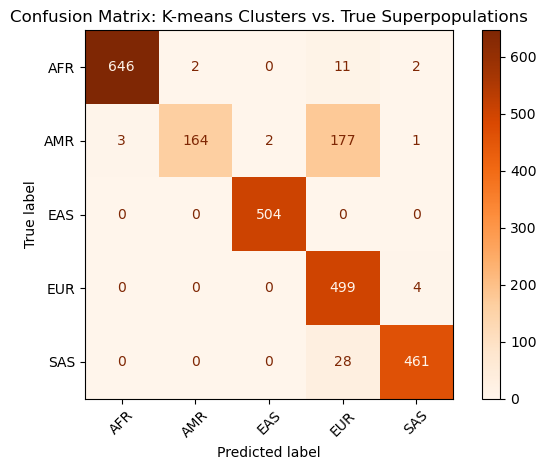

In [25]:
# Match clusters to superpopulation label
cluster_df = pd.DataFrame({
    'cluster': kmeans_labels,
    'superpop': superpop_labels
})

# Create mapping from cluster to dominant superpop
cluster_to_superpop = (
    cluster_df.groupby('cluster')['superpop']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

# Map each cluster label to the correct dominant superpopulation
predicted_superpops = [cluster_to_superpop[cluster] for cluster in kmeans_labels]

superpop_order = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']

# Compute confusion matrix
cm = confusion_matrix(superpop_labels, predicted_superpops, labels=superpop_order)

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=superpop_order)
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("Confusion Matrix: K-means Clusters vs. True Superpopulations")
plt.tight_layout()
plt.show()


The model demonstrates high overall accuracy, particularly for the AFR, EAS, EUR, and SAS populations. The main source of misclassification arises with the AMR population, which is split between its own cluster and the EUR group. This pattern suggests underlying genetic similarity between AMR and EUR populations.

Interestingly, the model recognize European features in AMR genomes and misclassifies them as EUR, while EUR individuals are not misclassified as AMR. This asymetrical misclassification likely reflects historically uneven genetic exchange: AMR populations (especially those from Central and South America) carry substantial European ancestry due to colonial-era admixture, whereas EUR populations lack reciprocal gene flow from the Americas.

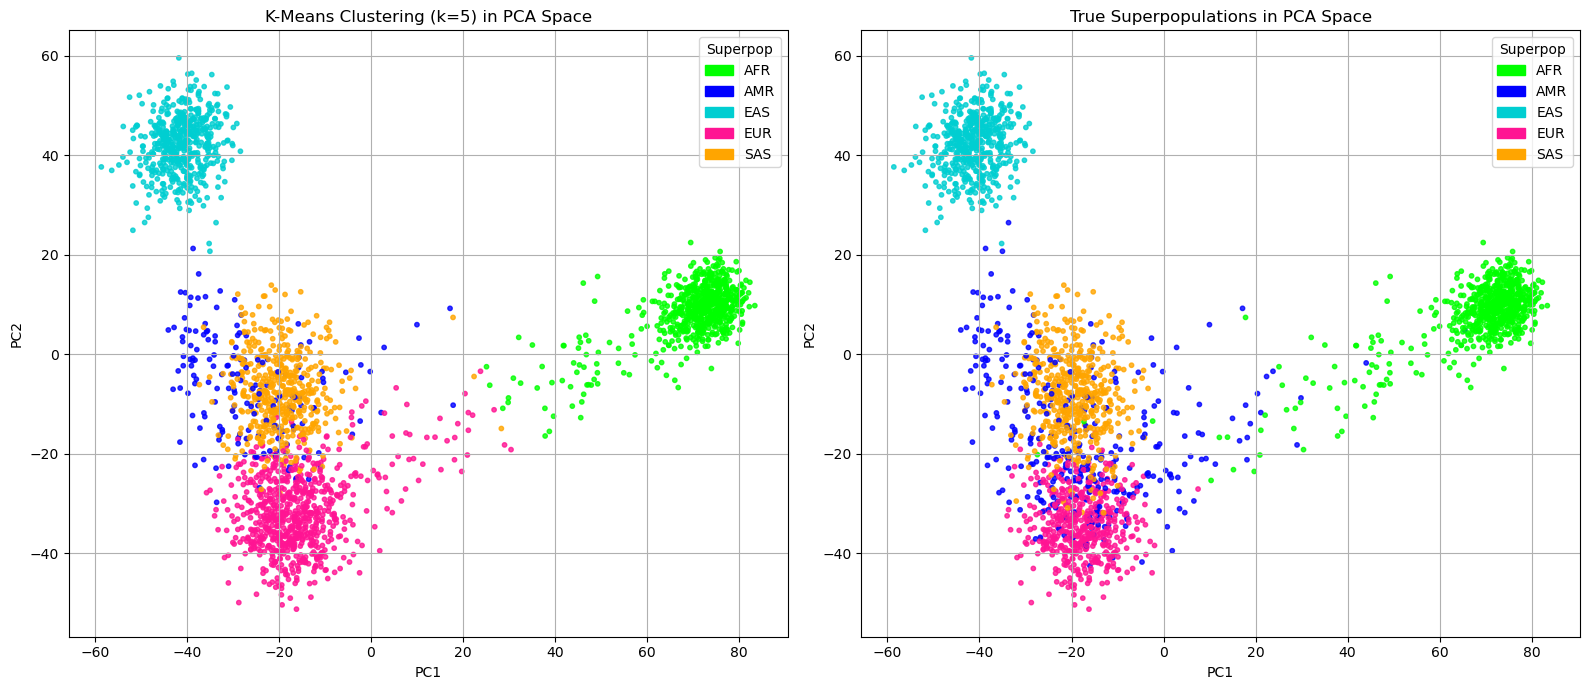

In [26]:
# Define color mapping
superpop_order = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']
color_palette = ['#00ff00', '#0000ff', '#00ced1', '#ff1493', '#ffa500']
superpop_to_color = dict(zip(superpop_order, color_palette))

# Map true superpopulation labels to color codes
superpop_labels_mapped = superpop_labels.map(superpop_to_color)

# Map K-means cluster labels to dominant superpopulations
cluster_df = pd.DataFrame({
    'cluster': kmeans_labels,
    'superpop': superpop_labels
})

cluster_to_superpop = (
    cluster_df.groupby('cluster')['superpop']
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)

cluster_colors = [superpop_to_color[cluster_to_superpop[c]] for c in kmeans_labels]

# Legend
legend_handles = [
    Patch(color=superpop_to_color[pop], label=pop) for pop in superpop_order
]

# Side by side plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# K-means clustering
axes[0].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=cluster_colors,
    s=10,
    alpha=0.8
)
axes[0].set_title("K-Means Clustering (k=5) in PCA Space")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)
axes[0].legend(handles=legend_handles, title="Superpop")

# True superpopulations
axes[1].scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=superpop_labels_mapped,
    s=10,
    alpha=0.8
)
axes[1].set_title("True Superpopulations in PCA Space")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)
axes[1].legend(handles=legend_handles, title="Superpop")

plt.tight_layout()
plt.show()


The left plot shows how K-means assigned clusters while the right panel shows the ground truth superpopulations. We see the AMR individuals (dark blue) are widely dispersed in both plots and frequently overlap with the EUR cluster (pink) in the left plot. The plot reinforces the confusion matrix by visually showing a key area of misclassification: many AMR individuals (dark blue) are incorrectly grouped with the EUR cluster (pink) in the K-means plot. This is evident when comparing corresponding points across the two plots.

In [27]:
# Agglomerative Clustering
k = 5 
agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
agglo_labels = agglo.fit_predict(X_pca)

# Evaluate
ari = adjusted_rand_score(superpop_labels, agglo_labels)
nmi = normalized_mutual_info_score(superpop_labels, agglo_labels)
purity = purity_score(superpop_labels, agglo_labels)

print(f"Agglomerative Clustering (k={k})\n")
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")
print(f"Purity Score: {purity}")


Agglomerative Clustering (k=5)

Adjusted Rand Index: 0.7950083165614241
Normalized Mutual Information: 0.8190894157333964
Purity Score: 0.896964856230032


Agglomerative clustering held up well compared to K-means, achieving similar performance across all metrics. In the next steps, I will explore ways to fine-tune the agglomerative model to see if it can exceed K-means in accuracy.

In [28]:
# Define linkage methods and distance metrics
linkage_methods = ['ward', 'average', 'complete', 'single']
distance_metrics = ['euclidean', 'manhattan', 'cosine']

# Results
results = []

for linkage in linkage_methods:
    for metric in distance_metrics:
        # ward linkage can only have euclidean metric
        if linkage == 'ward' and metric != 'euclidean':
            continue
        try:
            model = AgglomerativeClustering(
                n_clusters=5,
                linkage=linkage,
                metric=metric
            )
            labels = model.fit_predict(X_pca)

            purity = purity_score(superpop_labels, labels)
            ari = adjusted_rand_score(superpop_labels, labels)
            nmi = normalized_mutual_info_score(superpop_labels, labels)

            results.append({
                'Linkage': linkage,
                'Metric': metric,
                'Purity': purity,
                'ARI': ari,
                'NMI': nmi
            })
        except Exception as e:
            results.append({
                'Linkage': linkage,
                'Metric': metric,
                'Purity': None,
                'ARI': None,
                'NMI': None,
                'Error': str(e)
            })

# Convert results to dataframe & sort
results_df = pd.DataFrame(results).sort_values(by='Purity', ascending=False)
print(results_df)


    Linkage     Metric    Purity       ARI       NMI
1   average  euclidean  0.904553  0.834790  0.856727
2   average  manhattan  0.900559  0.834880  0.859840
0      ward  euclidean  0.896965  0.795008  0.819089
3   average     cosine  0.887780  0.815112  0.843852
6  complete     cosine  0.859824  0.805654  0.838520
4  complete  euclidean  0.710863  0.599837  0.743612
5  complete  manhattan  0.707668  0.599317  0.733480
8    single  manhattan  0.466054  0.221283  0.475452
7    single  euclidean  0.465256  0.220738  0.475189
9    single     cosine  0.265176  0.000080  0.004104


I looped through different combinations of linkage methods and distance metrics for agglomerative clustering. The best-performing configuration was average linkage with euclidean distance. Although tuning improved the performance of the agglomerative model, it still did not surpass the results of K-means clustering.

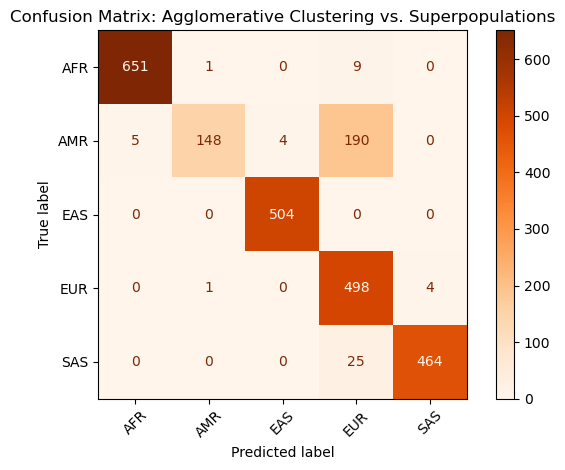

In [29]:
# Run agglomerative clustering with best parameters
best_model = AgglomerativeClustering(
    n_clusters=5,
    linkage='average',
    metric='euclidean'
)
best_labels = best_model.fit_predict(X_pca)

# Map cluster labels to superpopulations
cluster_df = pd.DataFrame({
    'cluster': best_labels,
    'superpop': superpop_labels
})
cluster_to_superpop = cluster_df.groupby('cluster')['superpop'].agg(lambda x: x.value_counts().idxmax()).to_dict()
predicted_superpops = [cluster_to_superpop[cluster] for cluster in best_labels]

# Confusion matrix
superpop_order = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']
cm = confusion_matrix(superpop_labels, predicted_superpops, labels=superpop_order)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=superpop_order)
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("Confusion Matrix: Agglomerative Clustering vs. Superpopulations")
plt.tight_layout()
plt.show()


This confusion matrix shows that, like K-means, the agglomerative clustering model frequently misclassified AMR individuals as EUR. This is most likely a result of genetic similarity due to admixture, making it difficult for the model to distinguish the two groups.

In [30]:
# Store results for each k
results = []

# Loop over number of clusters from 2 to 26
for k in range(2, 27):
    try:
        model = AgglomerativeClustering(n_clusters=k, linkage='average', metric='euclidean')
        labels = model.fit_predict(X_pca)

        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)
        purity = purity_score(true_labels, labels)

        results.append({
            'n_clusters': k,
            'ARI': ari,
            'NMI': nmi,
            'Purity': purity
        })
    except Exception as e:
        print(f"Failed for k={k}: {e}")

# Create a dataframe of results
results_df = pd.DataFrame(results)
print(results_df)

    n_clusters       ARI       NMI    Purity
0            2  0.048389  0.289540  0.087859
1            3  0.113525  0.460399  0.129792
2            4  0.136883  0.500362  0.160543
3            5  0.217374  0.583247  0.200879
4            6  0.223059  0.589397  0.211661
5            7  0.231384  0.593851  0.223243
6            8  0.231943  0.595389  0.224042
7            9  0.231953  0.595408  0.224840
8           10  0.230727  0.596154  0.233227
9           11  0.230556  0.595367  0.233227
10          12  0.230066  0.594119  0.233227
11          13  0.230075  0.594269  0.233626
12          14  0.230074  0.594359  0.233626
13          15  0.230046  0.594121  0.234026
14          16  0.229833  0.593510  0.234026
15          17  0.229572  0.593391  0.234824
16          18  0.228816  0.592055  0.237620
17          19  0.229066  0.590930  0.240016
18          20  0.228497  0.590327  0.240016
19          21  0.228869  0.590172  0.240815
20          22  0.228463  0.589693  0.240815
21        

Here I wanted to test whether agglomerative clustering could capture fine-grained genetic structure by distinguishing all 26 populations, unlike K-means which performed best with 5 clusters. However, the results show that even as the number of clusters increased, the ARI, NMI, and Purity scores were low. This indicates that agglomerative clustering was not able to recover detailed population-level differences present in the dataset.

In [31]:
import pandas as pd

# Create a comparison DataFrame for the three models
comparison_df = pd.DataFrame([

    {
        'Model': 'K-Means (k=5)',
        'ARI': 0.8343,
        'NMI': 0.8544,
        'Purity': 0.9081
    },
    {
        'Model': 'Agglomerative (avg, euclidean)',
        'ARI': 0.8350,
        'NMI': 0.8573,
        'Purity': 0.9050
    },
    {
        'Model': 'Random Clustering',
        'ARI': 0.1912,
        'NMI': 0.5070,
        'Purity': 0.3027
    },
])

print(comparison_df)

                            Model     ARI     NMI  Purity
0                   K-Means (k=5)  0.8343  0.8544  0.9081
1  Agglomerative (avg, euclidean)  0.8350  0.8573  0.9050
2               Random Clustering  0.1912  0.5070  0.3027
